In [21]:
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
import os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import tensorflow as tf

In [ ]:
!pip install kaggle

!kaggle datasets download -d sshikamaru/udacity-self-driving-car-dataset


In [ ]:
dataset_path = '/Users/Pauline/autonomous-vehicle-classifier/udacity-self-driving-car-dataset/data/export'
annotatinos_path = '/Users/Pauline/autonomous-vehicle-classifier/udacity-self-driving-car-dataset/data/export/_annotations.csv'

In [27]:
annotations_path = os.path.join(dataset_path, '_annotations.csv')
annotations = pd.read_csv(annotations_path)
image_files = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith('jpg')]

annotations.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,291,247,370,331
1,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,pedestrian,270,235,293,321
2,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,0,266,13,327
3,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,25,258,106,304
4,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,111,259,135,289


In [ ]:
for i in range (3):
    img = Image.open(image_files[i])
    plt.figure()
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.show()
    print(annotations.head)

In [ ]:
def iou(boxA, boxB):
    xA = max([boxA[0], boxB[0]])
    yA = max([boxA[1], boxB[1]])
    xB = min([boxA[2], boxB[2]])
    yB = min([boxA[3], boxB[3]])
    
    interArea = max(0, xB - xA+1) * max(0, yB - yA+1)
    
    #boxA = ground truth boxB = predicted
    boxAArea = (boxA[2] - boxA[0]+1) * (boxA[3] - boxA[1]+1)
    boxBArea = (boxB[2] - boxB[0]+1) * (boxB[3] - boxB[1]+1)
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

#remove 100% duplicate bounding boxes based on IoU threshold
def filter_duplicates(boxes, threshold=1):
    filtered_boxes = []
    for i, boxA in enumerate(boxes):
        to_add = True
        for boxB in filtered_boxes:
            if iou(boxA, boxB) == threshold:
                to_add = False
                break
        if to_add:
            filtered_boxes.append(boxA)
    return filtered_boxes

#example
bounding_boxes = [
    [100, 150, 200, 250],
    [100, 150, 200, 250],
    [110, 160, 210, 260],
]

filtered_boxes = filter_duplicates(bounding_boxes)
print(filtered_boxes)
iou_value = iou(bounding_boxes[0], bounding_boxes[1])
print(f"IoU between boxA and boxB: {iou_value}")

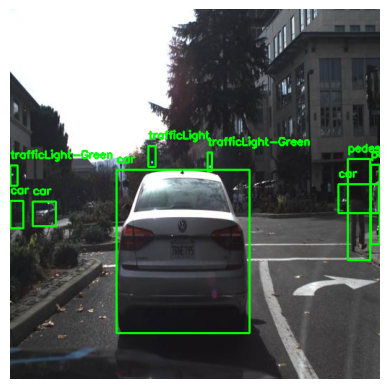

In [61]:
def draw_bounding_boxes(image_file, boxes, save_image=False, output_path=None):
    img_path = os.path.join(dataset_path, image_file)
    image = cv2.imread(img_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {img_path}")

    #draw each bounding box
    for _, row in boxes.iterrows():
        xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        label = row['class']

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        # label text
        cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    if save_image:
        if output_path:
            cv2.imwrite(output_path, image)  
        else:
            cv2.imwrite('output.jpg', image)  

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

image_file = "1478899844799782363_jpg.rf.RAjpKgjL9L1sH6Yztakh.jpg" 
boxes = annotations[annotations['filename'] == image_file]

if not boxes.empty: 
    
    draw_bounding_boxes(image_file, boxes)  
else:
    print(f"Image {image_file} not found in annotations.")

In [62]:
def normalize_bounding_boxes(bboxes, image_width, image_height):
    normalized_bboxes = []
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        
        #normalize bounding box coordinates
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height
        
        normalized_bboxes.append([x_center, y_center, width, height])
    
    return normalized_bboxes

image_width = 512
image_height = 512
bounding_boxes = [
    [100, 150, 200, 250], 
    [100, 150, 200, 250],
    [110, 160, 210, 260]
]

filtered_boxes = filter_duplicates(bounding_boxes)

normalized_boxes = normalize_bounding_boxes(filtered_boxes, image_width, image_height)

print(normalize_bounding_boxes(filtered_boxes,512,512))

[[0.29296875, 0.390625, 0.1953125, 0.1953125], [0.3125, 0.41015625, 0.1953125, 0.1953125]]


In [75]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.annotation_file = annotation_file
        self.transform = transform
        self.annotations = pd.read_csv(annotation_file) 

        #dictionary to map 11 class labels to integer values
        self.class_to_idx = {label: idx for idx, label in enumerate(self.annotations['class'].unique())}
        print(f"class to index: {self.class_to_idx}")

    def __len__(self):
        return len(self.annotations)  #total number of rows

    def __getitem__(self, idx):

        img_name = self.annotations.iloc[idx, 0]  
        
        if isinstance(img_name, list):
            img_name = img_name[0]
        
        img_name = os.path.join(self.image_dir, img_name)

        image = Image.open(img_name)
        
        boxes = self.annotations.iloc[idx, [4, 5, 6, 7]].values  
        
        boxes = boxes.astype(float)  
        

        class_label = self.annotations.iloc[idx, 3]  #class label in col 3
        label = self.class_to_idx[class_label]  #map class label to an integer using the class_to_idx dictionary
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)  #class labels should be long integers for classification

        # transformations not provided yet, but for future
        if self.transform:
            image = self.transform(image)

        return image, boxes, label


#define transformations: normalize imgs
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

dataset = ObjectDetectionDataset(image_dir=dataset_path, annotation_file=annotations_path, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

#test
for inputs, true_bboxes, true_classes in train_loader:
    print(f"Image batch shape: {inputs.shape}")
    print(f"Bounding box batch shape: {true_bboxes.shape}")
    print(f"Class label batch shape: {true_classes.shape}")
    break  #only check the first batch

class to index: {'car': 0, 'pedestrian': 1, 'biker': 2, 'truck': 3, 'trafficLight-Red': 4, 'trafficLight': 5, 'trafficLight-Green': 6, 'trafficLight-RedLeft': 7, 'trafficLight-GreenLeft': 8, 'trafficLight-Yellow': 9, 'trafficLight-YellowLeft': 10}
Image batch shape: torch.Size([32, 3, 512, 512])
Bounding box batch shape: torch.Size([32, 4])
Class label batch shape: torch.Size([32])


In [ ]:
class ObjectDetectionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #fully Connected Layers for classification and bb prediction
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  #image size of 512x512, output after 3 pooling layers: 128x16x16
        self.fc2 = nn.Linear(512, 256)
        
        #output layer for bounding boxes(4 values) and class probabilities (num_classes)
        self.fc3_bbox = nn.Linear(256, 4)  #  Bbox regression
        self.fc3_class = nn.Linear(256, 11)  #class prediction (11 classes)

    def forward(self, x):
        #pass through layers, batch normalization, and max pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        #flatten the output of the layers
        x = torch.flatten(x, 1)

        #fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        bbox = self.fc3_bbox(x) 
        class_prob = self.fc3_class(x)  

        return bbox, class_prob

In [ ]:
def detection_loss(pred_bboxes, pred_classes, true_bboxes, true_classes):
    #loss for bounding box regression
    bbox_loss = nn.MSELoss()(pred_bboxes, true_bboxes)
    
    #loss for classification
    class_loss = nn.CrossEntropyLoss()(pred_classes, true_classes)

    total_loss = bbox_loss + class_loss
    return total_loss


In [72]:
import torch.optim as optim

# Initialize the model
model = ObjectDetectionNet()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, true_bboxes, true_classes) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass
        pred_bboxes, pred_classes = model(inputs)

        # Compute the loss
        loss = detection_loss(pred_bboxes, pred_classes, true_bboxes, true_classes)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:  # Print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x524288 and 32768x512)